# Verifier Agent

In [24]:
import requests
import json
import qrcode
import uuid

In [25]:
# Set the URL for the API endpoint
# Need to specify the host as host.docker.internal as the Prism Agents and the Prism Playground are running in two isolated docker environments
base_url = "http://host.docker.internal:9000"

headers = {'Content-Type': 'application/json', 'accept': 'application/json'}

## Connections

### Create a connection record containing the invitation
```bash
curl -X 'POST' \
	'http://localhost:8080/prism-agent/connections' \
	-H 'Content-Type: application/json' \
	-d '{
		"label": "Connect with Alice"
		}' | jq
```

In [26]:
path = '/prism-agent/connections'
data = {"label": "Connect with Alice"}
# Make the request
response = requests.post(base_url + path, headers=headers, json=data)

# Check the response status code
if response.status_code == 201:
    # Print the response content
    loaded_json = json.loads(response.content.decode())
    print(json.dumps(loaded_json, indent=2))
    
else:
    # Print an error message
    print("Error: The API returned a non-201 status code")

{
  "connectionId": "8ebd0a1e-32b3-46a5-b4ad-2e4853ac5639",
  "createdAt": "2022-12-12T18:35:15.465292Z",
  "invitation": {
    "from": "did:peer:2.Ez6LSndby2jm4JgfNjZghLq3Sk5tLTPt5uhemniEd2g8EcRMq.Vz6MktbsYyvkquBe4VLw2tngasPur6tzKxBTweCDexzfoQzaC.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjkwMDAvZGlkY29tbSIsInIiOltdLCJhIjpbImRpZGNvbW0vdjIiXX0",
    "id": "8ebd0a1e-32b3-46a5-b4ad-2e4853ac5639",
    "invitationUrl": "https://domain.com/path?_oob=eyJpZCI6IjhlYmQwYTFlLTMyYjMtNDZhNS1iNGFkLTJlNDg1M2FjNTYzOSIsInR5cGUiOiJodHRwczovL2RpZGNvbW0ub3JnL291dC1vZi1iYW5kLzIuMC9pbnZpdGF0aW9uIiwiZnJvbSI6ImRpZDpwZWVyOjIuRXo2TFNuZGJ5MmptNEpnZk5qWmdoTHEzU2s1dExUUHQ1dWhlbW5pRWQyZzhFY1JNcS5WejZNa3Ric1l5dmtxdUJlNFZMdzJ0bmdhc1B1cjZ0ekt4QlR3ZUNEZXh6Zm9RemFDLlNleUowSWpvaVpHMGlMQ0p6SWpvaWFIUjBjRG92TDJodmMzUXVaRzlqYTJWeUxtbHVkR1Z5Ym1Gc09qa3dNREF2Wkdsa1kyOXRiU0lzSW5JaU9sdGRMQ0poSWpwYkltUnBaR052YlcwdmRqSWlYWDAiLCJib2R5Ijp7ImdvYWxfY29kZSI6ImNvbm5lY3QiLCJnb2FsIjoiRXN0YWJsaXNoIGEgdHJ1c3QgY29ubmVjdGlvbiBi

## Send invitation to Holder

In [27]:
invitation = json.loads(response.content.decode())
invitationUrl = invitation['invitation']['invitationUrl']
invitationUrlbase64verifier = invitation['invitation']['invitationUrl'].split('=')[1]
connection_id = invitation['connectionId']
%store invitationUrlbase64verifier

Stored 'invitationUrlbase64verifier' (str)


### Generate QR code from invitation

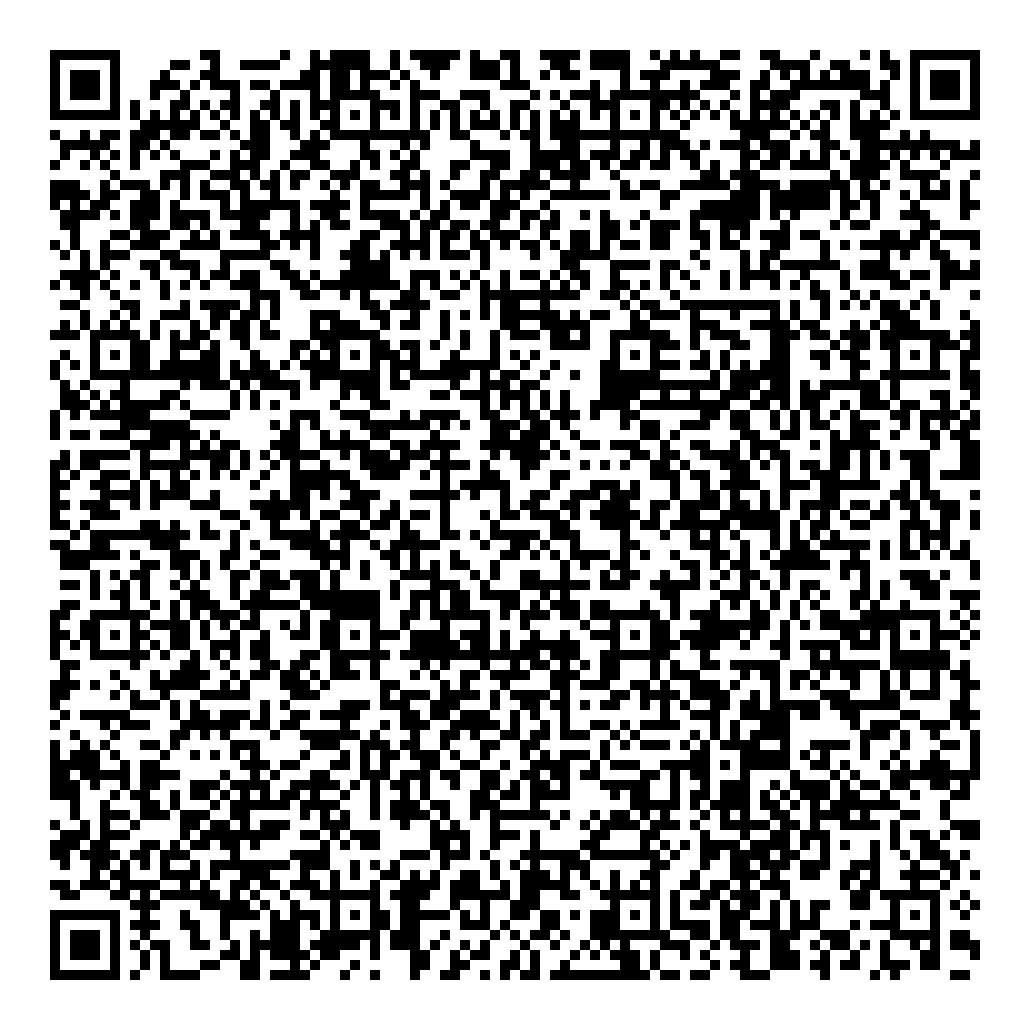

In [28]:
# Link for connection invitation
input_data = invitationUrl
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

### Retrieving the list of connections
```bash
curl -X 'GET' 'http://localhost:8080/prism-agent/connections' | jq
```

In [30]:
path = '/prism-agent/connections'

# Make the request
response = requests.get(base_url + path, headers=headers)

# Check the response status code
if response.status_code == 200:
    # Print the response content
    loaded_json = json.loads(response.content.decode())
    print(json.dumps(loaded_json, indent=2))
else:
    # Print an error message
    print("Error: The API returned a non-200 status code")

{
  "contents": [
    {
      "connectionId": "8ebd0a1e-32b3-46a5-b4ad-2e4853ac5639",
      "createdAt": "2022-12-12T18:35:15Z",
      "invitation": {
        "from": "did:peer:2.Ez6LSndby2jm4JgfNjZghLq3Sk5tLTPt5uhemniEd2g8EcRMq.Vz6MktbsYyvkquBe4VLw2tngasPur6tzKxBTweCDexzfoQzaC.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjkwMDAvZGlkY29tbSIsInIiOltdLCJhIjpbImRpZGNvbW0vdjIiXX0",
        "id": "8ebd0a1e-32b3-46a5-b4ad-2e4853ac5639",
        "invitationUrl": "https://domain.com/path?_oob=eyJpZCI6IjhlYmQwYTFlLTMyYjMtNDZhNS1iNGFkLTJlNDg1M2FjNTYzOSIsInR5cGUiOiJodHRwczovL2RpZGNvbW0ub3JnL291dC1vZi1iYW5kLzIuMC9pbnZpdGF0aW9uIiwiZnJvbSI6ImRpZDpwZWVyOjIuRXo2TFNuZGJ5MmptNEpnZk5qWmdoTHEzU2s1dExUUHQ1dWhlbW5pRWQyZzhFY1JNcS5WejZNa3Ric1l5dmtxdUJlNFZMdzJ0bmdhc1B1cjZ0ekt4QlR3ZUNEZXh6Zm9RemFDLlNleUowSWpvaVpHMGlMQ0p6SWpvaWFIUjBjRG92TDJodmMzUXVaRzlqYTJWeUxtbHVkR1Z5Ym1Gc09qa3dNREF2Wkdsa1kyOXRiU0lzSW5JaU9sdGRMQ0poSWpwYkltUnBaR052YlcwdmRqSWlYWDAiLCJib2R5Ijp7ImdvYWxfY29kZSI6ImNvbm5lY3QiLCJnb2FsIjoiR

In [32]:

path = '/prism-agent//connections/' + connection_id

# Make the request
response = requests.get(base_url + path, headers=headers)

# Check the response status code
if response.status_code == 200:
    # Print the response content
    loaded_json = json.loads(response.content.decode())
    print(json.dumps(loaded_json, indent=2))
    their_did = loaded_json['theirDid']
else:
    # Print an error message
    print("Error: The API returned a non-200 status code")

{
  "connectionId": "8ebd0a1e-32b3-46a5-b4ad-2e4853ac5639",
  "createdAt": "2022-12-12T18:35:15Z",
  "invitation": {
    "from": "did:peer:2.Ez6LSndby2jm4JgfNjZghLq3Sk5tLTPt5uhemniEd2g8EcRMq.Vz6MktbsYyvkquBe4VLw2tngasPur6tzKxBTweCDexzfoQzaC.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjkwMDAvZGlkY29tbSIsInIiOltdLCJhIjpbImRpZGNvbW0vdjIiXX0",
    "id": "8ebd0a1e-32b3-46a5-b4ad-2e4853ac5639",
    "invitationUrl": "https://domain.com/path?_oob=eyJpZCI6IjhlYmQwYTFlLTMyYjMtNDZhNS1iNGFkLTJlNDg1M2FjNTYzOSIsInR5cGUiOiJodHRwczovL2RpZGNvbW0ub3JnL291dC1vZi1iYW5kLzIuMC9pbnZpdGF0aW9uIiwiZnJvbSI6ImRpZDpwZWVyOjIuRXo2TFNuZGJ5MmptNEpnZk5qWmdoTHEzU2s1dExUUHQ1dWhlbW5pRWQyZzhFY1JNcS5WejZNa3Ric1l5dmtxdUJlNFZMdzJ0bmdhc1B1cjZ0ekt4QlR3ZUNEZXh6Zm9RemFDLlNleUowSWpvaVpHMGlMQ0p6SWpvaWFIUjBjRG92TDJodmMzUXVaRzlqYTJWeUxtbHVkR1Z5Ym1Gc09qa3dNREF2Wkdsa1kyOXRiU0lzSW5JaU9sdGRMQ0poSWpwYkltUnBaR052YlcwdmRqSWlYWDAiLCJib2R5Ijp7ImdvYWxfY29kZSI6ImNvbm5lY3QiLCJnb2FsIjoiRXN0YWJsaXNoIGEgdHJ1c3QgY29ubmVjdGlvbiBiZXR3ZWV

## Executing the `Verifier` flow
---
connectionId is the holder (connectionId or did)
Replace `{CONNECTION_ID}` with the DID of the holder displayed at startup in the his Prism Agent console logs

### Initiates a Proof Request

```shell
curl -X 'POST' \
  'http://localhost:8070/prism-agent/present-proof/presentations' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{
  "connectionId": "{CONNECTION_ID}", "proofs":[]
}'
```

In [56]:
path = '/prism-agent/present-proof/presentations'
data = {
  "connectionId": connection_id, "proofs":[]
}
# Make the request
response = requests.post(base_url + path, headers=headers, json=data)

# Check the response status code
if response.status_code == 201:
    # Print the response content
    loaded_json = json.loads(response.content.decode())
    print(json.dumps(loaded_json, indent=2))
    
else:
    # Print an error message
    print("Error: The API returned a non-201 status code")
    print(response.content)

{
  "presentationId": "1fed0513-7390-4b49-b0fe-97acb4881683"
}


### Send proof request to Holder

In [57]:
presentation_id = loaded_json['presentationId']
%store presentation_id
print(presentation_id)

Stored 'presentation_id' (str)
1fed0513-7390-4b49-b0fe-97acb4881683


### Check Presentation state  PresentationReceived 
> check PresentationReceived !
```shell
curl -X 'GET' 'http://localhost:8070/prism-agent/present-proof/presentations' -H 'accept: application/json' | jq
```


In [60]:
path = '/prism-agent/present-proof/presentations'

# Make the request
response = requests.get(base_url + path, headers=headers)

# Check the response status code
if response.status_code == 200:
    # Print the response content
    # print(response.content)
    loaded_json = json.loads(response.content.decode())
    print(json.dumps(loaded_json, indent=1))
    # proof_requestId = loaded_json[0]['presentationId']
else:
    # Print an error message
    print("Error: The API returned a non-200 status code")

[
 {
  "presentationId": "065ce5dd-c009-40d9-91a8-5408fc884441",
  "proofs": [],
  "status": "PresentationAccepted"
 },
 {
  "presentationId": "1fed0513-7390-4b49-b0fe-97acb4881683",
  "proofs": [],
  "status": "PresentationVerified"
 }
]


### Accept PresentationReceived 
> Replace `{PRESENTATION_ID}` with the UUID of the record from the presentation records list with state PresentationReceived

```shell
curl -X 'PATCH' \
  'http://localhost:8070/prism-agent/present-proof/presentations/{PRESENTATION_ID}' \
  -H 'Content-Type: application/json' \
  -d '{"action": "presentation-accept"}' | jq
```



In [61]:
data = {"action": "presentation-accept"}

path = '/prism-agent/present-proof/presentations/' + presentation_id

# Make the request
response = requests.patch(base_url + path, headers=headers, json=data)

# Check the response status code
if response.status_code == 200:
    # Print the response content
    print(response.content)
    # loaded_json = json.loads(response.content.decode())
    # print(json.dumps(loaded_json, indent=2))
    # proof_requestId = loaded_json[0]['presentationId']
else:
    # Print an error message
    print("Error: The API returned a non-200 status code")
    print(response.content)

Error: The API returned a non-200 status code
b'Resource representation is only available with these types:\ntext/plain'


### Check Presentation state  PresentationVerified 
> check PresentationVerified !

```shell
curl -X 'GET' 'http://localhost:8070/prism-agent/present-proof/presentations' -H 'accept: application/json' | jq
```

In [62]:
path = '/prism-agent/present-proof/presentations'

# Make the request
response = requests.get(base_url + path, headers=headers)

# Check the response status code
if response.status_code == 200:
    # Print the response content
    loaded_json = json.loads(response.content.decode())
    print(json.dumps(loaded_json, indent=2))
    
else:
    # Print an error message
    print("Error: The API returned a non-200 status code")
    print(response.content)

[
  {
    "presentationId": "065ce5dd-c009-40d9-91a8-5408fc884441",
    "proofs": [],
    "status": "PresentationAccepted"
  },
  {
    "presentationId": "1fed0513-7390-4b49-b0fe-97acb4881683",
    "proofs": [],
    "status": "PresentationAccepted"
  }
]


## DIDs

### Create a new unpublised DID stored in Prism Agent
```bash
curl --location --request POST 'http://localhost:8080/prism-agent/did-registrar/dids' \
  --header 'Content-Type: application/json' \
  --header 'Accept: application/json' \
  --data-raw '{
    "documentTemplate": {
      "publicKeys": [
        {
          "id": "auth0",
          "purpose": "authentication"
        }
      ],
      "services": []
    }
  }'
```

In [ ]:
path = '/prism-agent/did-registrar/dids'
data = {
    "documentTemplate": {
      "publicKeys": [
        {
          "id": "auth0",
          "purpose": "authentication"
        }
      ],
      "services": []
    }
  }

# Make the request
response = requests.post(base_url + path, headers=headers, json=data)

# Check the response status code
if response.status_code == 200:
    # Print the response content
    loaded_json = json.loads(response.content.decode())
    print(json.dumps(loaded_json, indent=2))
    
else:
    # Print an error message
    print("Error: The API returned a non-200 status code")
    print(response.content)

### Lists all the DIDs in Prism Agent
```bash
curl --location --request GET 'http://localhost:8080/prism-agent/did-registrar/dids' \
  --header 'Accept: application/json'
```



In [ ]:
path = '/prism-agent/did-registrar/dids'

# Make the request
response = requests.get(base_url + path, headers=headers)

# Check the response status code
if response.status_code == 200:
    # Print the response content
    loaded_json = json.loads(response.content.decode())
    print(json.dumps(loaded_json, indent=2))
    DID_REF = loaded_json[0]['longFormDid']
    DID_REF_SHORT = loaded_json[0]['did']
else:
    # Print an error message
    print("Error: The API returned a non-200 status code")
    print(response.content)

### Publishes the DID in Prism Agent to the blockchain
Replace `DID_REF` by the DID on Prism Agent that should be published
```bash
curl --location --request POST 'http://localhost:8080/prism-agent/did-registrar/dids/{DID_REF}/publications' \
--header 'Accept: application/json'
```

In [ ]:
path = '/prism-agent/did-registrar/dids/' + DID_REF + '/publications'

# Make the request
response = requests.post(base_url + path, headers=headers)

# Check the response status code
if response.status_code == 202:
    # Print the response content
    loaded_json = json.loads(response.content.decode())
    print(json.dumps(loaded_json, indent=2))
    
else:
    # Print an error message
    print("Error: The API returned a non-202 status code")
    print(response.content)

### Resolves the DID document of Prism DID
Replace `DID_REF` by the DID on Prism Agent that should be resolved
```bash
curl --location --request GET 'http://localhost:8080/prism-agent/dids/{DID_REF}' \
--header 'Accept: application/json'
```

In [ ]:
path = '/prism-agent/dids/' + DID_REF

# Make the request
response = requests.get(base_url + path, headers=headers)

# Check the response status code
if response.status_code == 200:
    # Print the response content
    loaded_json = json.loads(response.content.decode())
    print(json.dumps(loaded_json, indent=2))
    
else:
    # Print an error message
    print("Error: The API returned a non-200 status code")
    print(response.content)